In [1]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from itertools import product

import numpy as np
import areametric as am
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

In [2]:
pallette = {'brattle.blue':   (0,70,127),
            'aqua':           (127,185,194),
            'orange':         (244,119,53),
            'citron.light':   (245,237,96),
            'olive.light':    (176,188,34),
            'red':            (239,70,35),
            'plum':           (102,4,96),
            'emerald':        (0,161,142),
            'citron':         (213,209,14),
            'olive':          (138,141,9)
    }

For one-dimensional normal distributions ($X \sim N(\mu_x, \sigma^2_x), Y \sim N(\mu_y, \sigma^2_y)$) the wasserstein distance is bounded by:
$$
\begin{align}
\overbrace{\lvert \mu_x - \mu_y \rvert}^{W^{LB}(X,Y)} \leq \underbrace{\int_0^1\lvert F^{-1}_1(q)- F^{-1}_2(q)\rvert dq}_{W(X,Y)} \leq \overbrace{\lvert \mu_x - \mu_y \rvert + \sqrt{\frac{2}{\pi}}\lvert \sigma_x - \sigma_y \rvert}^{W^{UB}(X,Y)}
\end{align}
$$

$$
\begin{align}
\int_0^1\lvert F^{-1}_1(q)- F^{-1}_2(q)\rvert dq &= \int_0^1\lvert \left(\mu_1 + \sigma_1\Phi^{-1}(q)\right) - \left(\mu_2 + \sigma_2\Phi^{-1}(q)\right)\rvert dq \\
&= \int_0^1\lvert \mu_1 - \mu_2 + \left(\sigma_1-\sigma_2\right)\Phi^{-1}(q)\rvert dq \\
&= E[Z] \quad \text{where } Z \sim FN(\lvert\mu_1 - \mu_2\rvert, \lvert\sigma_1-\sigma_2\rvert^2)\\
&= \sigma_z \sqrt{\frac{2}{\pi}} \exp{\left(\frac{-\mu_z^2}{2\sigma_z^2}\right) + \mu_z \left[ 1- 2 \Phi\left(\frac{-\mu_z}{\sigma_z}\right) \right]}
\end{align}
$$

The mean absolute error ($U(X,Y)$) between normally distributed data can be characterised as a folded normal with the following mean:
$$
\begin{align}
U(X,Y) = \mathbb{E} \lvert X - Y \rvert = \overbrace{\sigma_z \sqrt{\frac{2}{\pi}} \exp{\left(\frac{-\mu_z^2}{2\sigma_z^2}\right) + \mu_z \left[ 1- 2 \Phi\left(\frac{-\mu_z}{\sigma_z}\right) \right]}}^{U^{FN}(X,Y)}
\end{align}
$$
where $Z = X-Y$ with $\mu_z = \mu_x - \mu_y$ and $\sigma_z = \sqrt{\sigma^2_x + \sigma^2_y}$

If $Y$ is a fixed value then:

$$
\begin{align}
\lvert U(X_1,Y) - U(X_2,Y) \rvert &= \lvert \sigma_1\sqrt{\frac{2}{\pi}} + \lvert \mu_1 - \mu_y \rvert 
 - \sigma_2\sqrt{\frac{2}{\pi}} - \lvert \mu_2 - \mu_y \rvert \rvert \\
 &=  \lvert \left(\sigma_1 - \sigma_2\right)\sqrt{\frac{2}{\pi}} + \lvert \mu_1 - \mu_y \rvert 
 - \lvert \mu_2 - \mu_y \rvert \rvert \\
 &\leq  \lvert\sigma_1 - \sigma_2 \rvert\sqrt{\frac{2}{\pi}} + \lvert \lvert \mu_1 - \mu_y \rvert 
 - \lvert \mu_2 - \mu_y \rvert \rvert \\
 & \leq \lvert\sigma_1 - \sigma_2 \rvert\sqrt{\frac{2}{\pi}} + \lvert  \mu_1 - \mu_2 \rvert \\
 & = W^{UB}(X_1,X_2)
\end{align}

$$

In [130]:
def calc_U(μ_a,μ_b,σ_a,σ_b):
    # folded normal https://en.wikipedia.org/wiki/Folded_normal_distribution
    μ  = μ_a-μ_b
    σ = np.sqrt(σ_a**2 + σ_b**2)
    if σ == 0:
        return np.abs(μ)
    else:
        return σ*np.sqrt(2/np.pi)*np.exp(-μ**2/(2*σ**2)) + μ*(1-2*norm.cdf(-μ/σ))

def calc_U_LB(μ_a,μ_b,σ_a,σ_b):
    return np.abs(μ_a-μ_b)

def calc_U_UB(μ_a,μ_b,σ_a,σ_b):
    μ  = μ_a-μ_b
    σ = np.sqrt(σ_a**2 + σ_b**2)
    return np.abs(μ) + σ*np.sqrt(2/np.pi)

def calc_W(μ_a,μ_b,σ_a,σ_b):
    # folded normal https://en.wikipedia.org/wiki/Folded_normal_distribution
    μ  = np.abs(μ_a-μ_b)
    σ = np.abs(σ_a - σ_b)
    if σ == 0:
        return np.abs(μ)
    else:
        return σ*np.sqrt(2/np.pi)*np.exp(-μ**2/(2*σ**2)) + μ*(1-2*norm.cdf(-μ/σ))
    
def calc_W_LB(μ_a,μ_b,σ_a,σ_b):
    return np.abs(μ_a-μ_b)

def calc_W_UB(μ_a,μ_b,σ_a,σ_b):
    return np.abs(μ_a-μ_b) + np.abs(σ_a-σ_b)*np.sqrt(2/np.pi)#*np.exp(-(μ_a-μ_b)**2/(2*np.sqrt((σ_a**2+σ_b**2))))

# def calc_W_Lip(μ_a,μ_b,σ_a,σ_b):
#     if np.abs(μ_a-μ_b) > 0:
#         return (1+((np.sqrt(σ_a**2 + σ_b**2))*np.sqrt(2/np.pi))/np.abs(μ_a-μ_b))
#     else: 
#         return (np.sqrt(σ_a**2 + σ_b**2))*np.sqrt(2/np.pi)
    
np.random.seed(0)
N_r = 10 # number of simulations
N_s = 10000 # number of samples

# data range
μ_1 = np.arange(0,15,1)
μ_2 = np.arange(0,15,1)
σ_1 = np.arange(0,15,1)
σ_2 = np.arange(0,15,1)

# Simulated values (E)
E_U = np.empty((len(μ_1),len(σ_1),len(μ_2),len(σ_2),N_r))
E_W = np.empty_like(E_U)

# Calculated values
W_FN = np.empty((len(μ_1),len(σ_1),len(μ_2),len(σ_2)))
W_UB = np.empty_like(W_FN)
W_LB = np.empty_like(W_UB)
W_Lip = np.empty_like(W_UB)
U_FN = np.empty_like(W_UB)
U_UB = np.empty_like(W_UB)
U_LB = np.empty_like(W_UB)

# Initialise as nan
arr_list = [
    E_U, E_W, W_FN, W_UB,W_LB,U_FN, U_LB, U_UB
]
for arr in arr_list:
    arr[:] = np.nan

for comb in tqdm(product(range(len(μ_1)),range(len(σ_1)),range(len(μ_2)),range(len(σ_2)))):
    U_FN[comb] = calc_U(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    U_UB[comb] = calc_U_UB(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    U_LB[comb] = calc_U_LB(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    W_FN[comb] = calc_W(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    W_UB[comb] = calc_W_UB(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    W_LB[comb] = calc_W_LB(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    
    for m in range(N_r):
        μ = np.array([μ_1[comb[0]],μ_2[comb[2]]])
        Σ = np.array([σ_1[comb[1]]**2,σ_2[comb[3]]**2])*np.identity(2)
        X = np.random.multivariate_normal(μ,Σ,N_s)
        E_U[comb+(m,)] = mean_absolute_error(X[:,0], X[:,1])
        E_W[comb+(m,)] = wasserstein_distance(X[:,0], X[:,1])        
    # L = calc_W_Lip(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    # W_Lip[comb] = L*E_W[comb].mean()

0it [00:00, ?it/s]

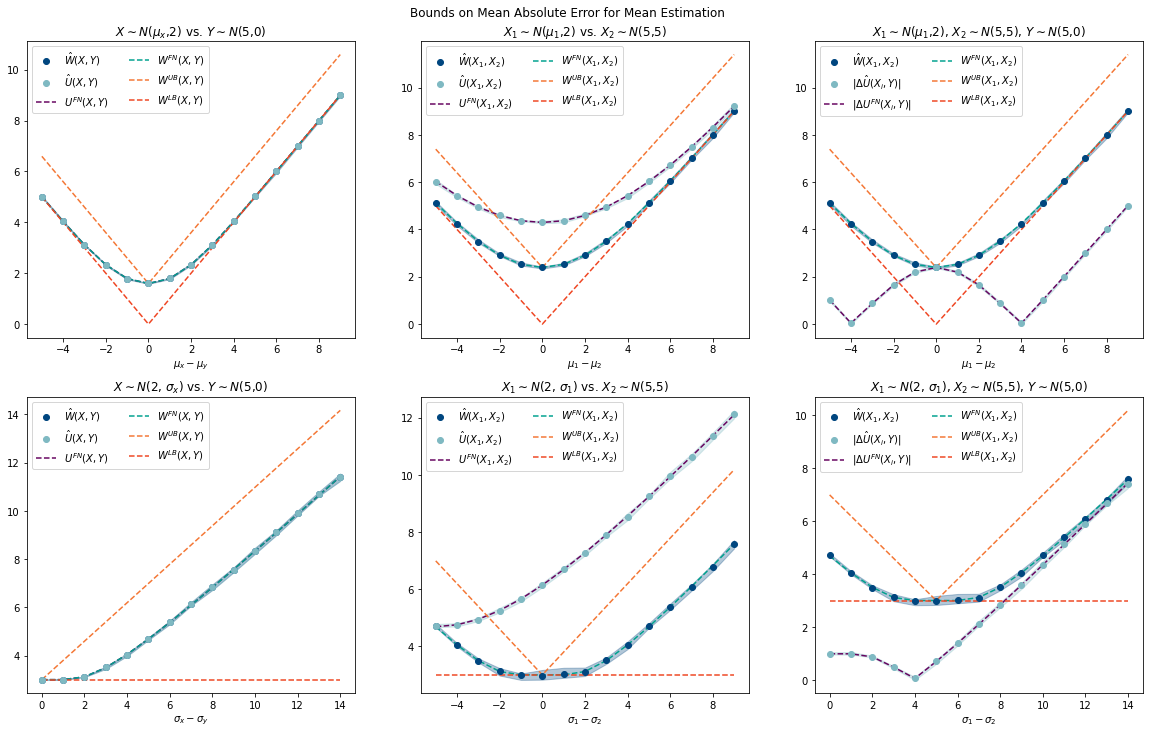

In [140]:
fig, axes = plt.subplots(2,3, figsize = (20,12))
cpal = [tuple([x[0]/255,x[1]/255,x[2]/255]) for x in list(pallette.values())]

# target distribution
μ_y = 5
σ_y = 0

# Difference between X and target Y (fixed value)
# E[|X_1 - Y|] <= L⋅W(X_1, Y)
x = μ_1-μ_y
j = 2
axes[0,0].set_title("$X \sim N$($\mu_x$,{}) vs. $Y \sim N$({},{})".format(σ_1[j],μ_y,σ_y))
axes[0,0].fill_between(x, E_W[:,j,μ_y,σ_y].min(axis=1),E_W[:,j,μ_y,σ_y].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[0,0].fill_between(x, E_U[:,j,μ_y,σ_y].min(axis=1),E_U[:,j,μ_y,σ_y].max(axis=1), alpha = 0.3, color = cpal[1],zorder = 0)
axes[0,0].scatter(x, E_W[:,j,μ_y,σ_y].mean(axis=1),label = "$\hat W(X,Y)$", color = cpal[0],  zorder = 10)
axes[0,0].scatter(x, E_U[:,j,μ_y,σ_y].mean(axis=1), label = "$\hat U(X,Y)$", color = cpal[1], zorder = 10)
axes[0,0].plot(x,U_FN[:,j,μ_y,σ_y], label = "$U^{FN}(X,Y)$", ls = '--', color = cpal[6], zorder = 5)
axes[0,0].plot(x,W_FN[:,j,μ_y,σ_y], label = "$W^{FN}(X,Y)$", ls = '--', color = cpal[7],zorder = 5)
axes[0,0].plot(x,W_UB[:,j,μ_y,σ_y], label = "$W^{UB}(X,Y)$", ls = '--', color = cpal[2], zorder = 5)
axes[0,0].plot(x,W_LB[:,j,μ_y,σ_y], label = "$W^{LB}(X,Y)$", ls = '--', color = cpal[5],zorder = 5)
axes[0,0].set_xlabel("$\mu_x - \mu_y$")

x = σ_1-σ_y
i = 2
axes[1,0].set_title("$X \sim N$({}, $\sigma_x$) vs. $Y \sim N$({},{})".format(μ_1[i],μ_y,σ_y))
axes[1,0].fill_between(x, E_W[i,:,μ_y,σ_y].min(axis=1),E_W[i,:,μ_y,σ_y].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[1,0].fill_between(x, E_U[i,:,μ_y,σ_y].min(axis=1),E_U[i,:,μ_y,σ_y].max(axis=1), alpha = 0.3, color = cpal[1],zorder = 0)
axes[1,0].scatter(x, E_W[i,:,μ_y,σ_y].mean(axis=1),label = "$\hat W(X,Y)$", color = cpal[0],  zorder = 10)
axes[1,0].scatter(x, E_U[i,:,μ_y,σ_y].mean(axis=1), label = "$\hat U(X,Y)$", color = cpal[1], zorder = 10)
axes[1,0].plot(x,U_FN[i,:,μ_y,σ_y], label = "$U^{FN}(X,Y)$", ls = '--', color = cpal[6], zorder = 5)
axes[1,0].plot(x,W_FN[i,:,μ_y,σ_y], label = "$W^{FN}(X,Y)$", ls = '--', color = cpal[7],zorder = 5)
axes[1,0].plot(x,W_UB[i,:,μ_y,σ_y], label = "$W^{UB}(X,Y)$", ls = '--', color = cpal[2], zorder = 5)
axes[1,0].plot(x,W_LB[i,:,μ_y,σ_y], label = "$W^{LB}(X,Y)$", ls = '--', color = cpal[5],zorder = 5)
axes[1,0].set_xlabel("$\sigma_x - \sigma_y$")

# Difference between X1 and X2 (both rv)
# E[|X_1 - X_2|] <= L⋅W(X_1, X_2)
j = 2
k = 5
l = 5
x = μ_1-μ_2[k]
axes[0,1].set_title("$X_1\sim N$($\mu_1$,{}) vs. $X_2 \sim N$({},{})".format(σ_1[j],μ_2[k],σ_2[l]))
axes[0,1].fill_between(x, E_W[:,j,k,l].min(axis=1),E_W[:,j,k,l].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[0,1].fill_between(x, E_U[:,j,k,l].min(axis=1),E_U[:,j,k,l].max(axis=1), alpha = 0.3, color = cpal[1],zorder = 0)
axes[0,1].scatter(x, E_W[:,j,k,l].mean(axis=1),label = "$\hat W(X_1,X_2)$", color = cpal[0],  zorder = 10)
axes[0,1].scatter(x, E_U[:,j,k,l].mean(axis=1), label = "$\hat U(X_1,X_2)$", color = cpal[1], zorder = 10)
axes[0,1].plot(x,U_FN[:,j,k,l], label = "$U^{FN}(X_1,X_2)$", ls = '--', color = cpal[6], zorder = 5)
axes[0,1].plot(x,W_FN[:,j,k,l], label = "$W^{FN}(X_1,X_2)$", ls = '--', color = cpal[7],zorder = 5)
axes[0,1].plot(x,W_UB[:,j,k,l], label = "$W^{UB}(X_1,X_2)$", ls = '--', color = cpal[2], zorder = 5)
axes[0,1].plot(x,W_LB[:,j,k,l], label = "$W^{LB}(X_1,X_2)$", ls = '--', color = cpal[5],zorder = 5)
axes[0,1].set_xlabel("$\mu_1 - \mu_2$")

i = 2
x = σ_1-σ_2[k]
axes[1,1].set_title("$X_1\sim N$({}, $\sigma_1$) vs. $X_2 \sim N$({},{})".format(μ_1[i],μ_2[k],σ_2[l]))
axes[1,1].fill_between(x, E_W[i,:,k,l].min(axis=1),E_W[i,:,k,l].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[1,1].fill_between(x, E_U[i,:,k,l].min(axis=1),E_U[i,:,k,l].max(axis=1), alpha = 0.3, color = cpal[1],zorder = 0)
axes[1,1].scatter(x, E_W[i,:,k,l].mean(axis=1),label = "$\hat W(X_1,X_2)$", color = cpal[0],  zorder = 10)
axes[1,1].scatter(x, E_U[i,:,k,l].mean(axis=1), label = "$\hat U(X_1,X_2)$", color = cpal[1], zorder = 10)
axes[1,1].plot(x,U_FN[i,:,k,l], label = "$U^{FN}(X_1,X_2)$", ls = '--', color = cpal[6], zorder = 5)
axes[1,1].plot(x,W_FN[i,:,k,l], label = "$W^{FN}(X_1,X_2)$", ls = '--', color = cpal[7],zorder = 5)
axes[1,1].plot(x,W_UB[i,:,k,l], label = "$W^{UB}(X_1,X_2)$", ls = '--', color = cpal[2], zorder = 5)
axes[1,1].plot(x,W_LB[i,:,k,l], label = "$W^{LB}(X_1,X_2)$", ls = '--', color = cpal[5],zorder = 5)
axes[1,1].set_xlabel("$\sigma_1 - \sigma_2$")

# Lipschitz Bounds on errors
# E[|X_1 - Y|] - E[|X_2 - Y|] <= L⋅W(X_1, X_2)

j = 2
k = 5
l = 5
x = μ_1-μ_y
E_U_Y =  np.abs(E_U[:,:,μ_y,σ_y,:] - E_U[k,l,μ_y,σ_y,:])
U_FN_Y = np.abs(U_FN[:,:,μ_y,σ_y] - U_FN[k,l,μ_y,σ_y])
axes[0,2].set_title("$X_1\sim N$($\mu_1$,{}), $X_2 \sim N$({},{}), $Y \sim N$({},{})".format(σ_1[i],μ_2[k],σ_2[l],μ_y,σ_y))
axes[0,2].fill_between(x, E_W[:,j,k,l].min(axis=1),E_W[:,j,k,l].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[0,2].fill_between(x, E_U_Y[:,j].min(axis=1),E_U_Y[:,j].max(axis=1), alpha = 0.3, color = cpal[1],zorder = 0)
axes[0,2].scatter(x, E_W[:,j,k,l].mean(axis=1), label = "$\hat W (X_1,X_2)$", color = cpal[0],  zorder = 10)
axes[0,2].scatter(x, E_U_Y[:,j].mean(axis=1),label = "$|\Delta \hat U(X_i,Y)|$", color = cpal[1], zorder = 10)
axes[0,2].plot(x,U_FN_Y[:,j], label = "$|\Delta U^{FN}(X_i,Y)|$", ls = '--', color = cpal[6], zorder = 5)
axes[0,2].plot(x,W_FN[:,j,k,l], label = "$W^{FN}(X_1,X_2)$", ls = '--', color = cpal[7],zorder = 5)
axes[0,2].plot(x,W_UB[:,j,k,l], label = "$W^{UB}(X_1,X_2)$", ls = '--', color = cpal[2], zorder = 5)
axes[0,2].plot(x,W_LB[:,j,k,l], label = "$W^{LB}(X_1,X_2)$", ls = '--', color = cpal[5],zorder = 5)
axes[0,2].set_xlabel("$\mu_1 - \mu_2$")

i = 2
x = σ_1-σ_y
axes[1,2].set_title("$X_1\sim N$({}, $\sigma_1$), $X_2 \sim N$({},{}), $Y \sim N$({},{})".format(μ_1[i],μ_2[k],σ_2[l],μ_y,σ_y))
axes[1,2].fill_between(x, E_W[i,:,k,l].min(axis=1),E_W[i,:,k,l].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[1,2].fill_between(x, E_U_Y[i,:].min(axis=1),E_U_Y[i,:].max(axis=1), alpha = 0.3, color = cpal[1],zorder = 0)
axes[1,2].scatter(x, E_W[i,:,k,l].mean(axis=1), label = "$\hat W (X_1,X_2)$", color = cpal[0],  zorder = 10)
axes[1,2].scatter(x, E_U_Y[i,:].mean(axis=1),label = "$|\Delta \hat U(X_i,Y)|$", color = cpal[1], zorder = 10)
axes[1,2].plot(x,U_FN_Y[i,:], label = "$|\Delta U^{FN}(X_i,Y)|$", ls = '--', color = cpal[6], zorder = 5)
axes[1,2].plot(x,W_FN[i,:,k,l], label = "$W^{FN}(X_1,X_2)$", ls = '--', color = cpal[7],zorder = 5)
axes[1,2].plot(x,W_UB[i,:,k,l], label = "$W^{UB}(X_1,X_2)$", ls = '--', color = cpal[2], zorder = 5)
axes[1,2].plot(x,W_LB[i,:,k,l], label = "$W^{LB}(X_1,X_2)$", ls = '--', color = cpal[5],zorder = 5)
axes[1,2].set_xlabel("$\sigma_1 - \sigma_2$")

for ax in axes.ravel():
    ax.legend(ncol=2);
fig.suptitle("Bounds on Mean Absolute Error for Mean Estimation", y=0.92);

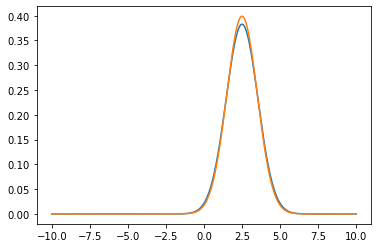

In [115]:
x = np.linspace(-10,10,1000)
y_c = norm.cdf(x,loc = 2,scale = 1) - norm.cdf(x,loc = 3,scale = 1)
y_p = norm.pdf(x,loc = 2.5,scale = 1)
plt.plot(x,y_c)
plt.plot(x,y_p)

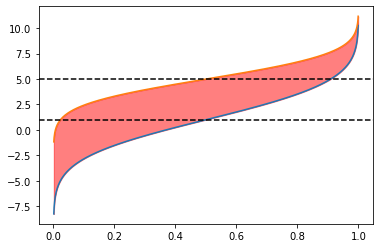

In [46]:
x = np.linspace(0,1,1000)
μ_1 = 1
μ_2 = 5
σ_1 = 3
σ_2 = 2
y1 = norm.ppf(x, loc = μ_1, scale = σ_1)
y2 = norm.ppf(x, loc = μ_2, scale = σ_2)
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x, y1, y2, alpha = 0.5, color = 'r')
plt.axhline(μ_1, color = 'k', ls = '--')
plt.axhline(μ_2, color = 'k', ls = '--')

In [40]:
from scipy import integrate
μ_x = 2
μ_y = 1
σ_x = 10
σ_y = 1

norm_cdf = lambda x,mu,sig: norm.cdf(x, loc = mu , scale = sig)
cdf1 = integrate.quad(norm_cdf, -np.inf, μ_x, args=(μ_x,σ_x))[0]*2
cdf2 = integrate.quad(norm_cdf, -np.inf, μ_y, args=(μ_y,σ_y))[0]*2
print("CDF: %.2f" %np.abs(cdf1-cdf2))

norm_ppf = lambda x,mu,sig: np.abs(norm.ppf(x, loc = mu , scale = sig))
ppf1 = integrate.quad(norm_ppf, 0, 1, args=(μ_x,σ_x))[0]
ppf2 = integrate.quad(norm_ppf, 0, 1, args=(μ_y,σ_y))[0]
print("PPF: %.2f" %np.abs(ppf1-ppf2))

N = 10000
R = 100
E_W = 0
for r in range(R):
    E_W += wasserstein_distance(np.random.normal(μ_x,σ_x,N),np.random.normal(μ_y,σ_y,N))
print("W: %.2f" %(E_W/R))

C_W = np.abs(μ_x - μ_y) + np.abs(σ_x- σ_y)*np.sqrt(2/np.pi)
print("Closed: %.2f" % C_W)

CDF: 7.18
PPF: 6.97
W: 7.22
Closed: 8.18


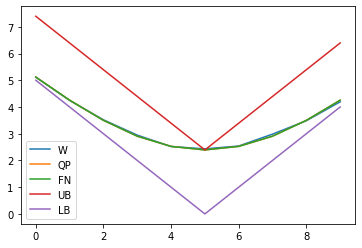

In [89]:
N = 10000
μ_1_range = np.arange(0,10,1)
μ_2 = 5
σ_1 = 2
σ_2 = 5
W = [wasserstein_distance(np.random.normal(μ_1,σ_1,N),np.random.normal(μ_2,σ_2,N)) for μ_1 in μ_1_range]
QP = [integrate.quad(norm_ppf, 0, 1, args=(np.abs(μ_1 - μ_2),np.abs(σ_1 - σ_2)))[0] for μ_1 in μ_1_range]
FN = [np.abs(σ_1 - σ_2)*np.sqrt(2/np.pi)*np.exp(-np.abs(μ_1 - μ_2)**2/(2*np.abs(σ_1 - σ_2)**2)) +\
       np.abs(μ_1 - μ_2)*(1-2*norm.cdf(-np.abs(μ_1 - μ_2)/np.abs(σ_1 - σ_2))) for μ_1 in μ_1_range]
UB = [np.abs(μ_1 - μ_2)+np.abs(σ_1 - σ_2)*np.sqrt(2/np.pi) for μ_1 in μ_1_range]
LB = [np.abs(μ_1 - μ_2) for μ_1 in μ_1_range]

plt.plot(W, label = 'W')
plt.plot(QP, label = 'QP')
plt.plot(FN, label = 'FN')
plt.plot(UB, label = 'UB')
plt.plot(LB, label = 'LB')
plt.legend();

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\Saurab\AppData\Local\Temp\ipykernel_20940\2985748436.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  QP = [integrate.quad(norm_ppf, 0, 1, args=(np.abs(μ_1 - μ_2),np.abs(σ_1 - σ_2)))[0] for σ_1 in σ_1_range]
C:\Users\Saurab\AppData\Local\Temp\ipykernel_20940\2985748436.py:8: RuntimeWarning: divide by zero encountered in true_divide
  FN = [np.abs(σ_1 - σ_2)*np.sqrt(2/np.pi)*np.exp(-np.abs(μ_1 - μ_2)**2/(2*np.abs(σ_1 - σ_2)**2)) +\
C:\Users\Saurab\AppData\Local\Temp\ipykernel_20940\2985748436.py:9: RuntimeWarning: d

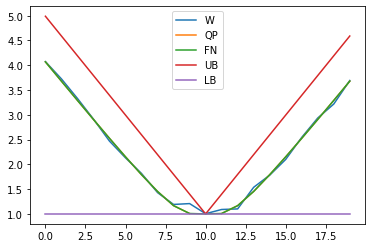

In [87]:
N = 10000
μ_1 = 4
μ_2 = 5
σ_1_range = np.arange(0,10,0.5)
σ_2 = 5
W = [wasserstein_distance(np.random.normal(μ_1,σ_1,N),np.random.normal(μ_2,σ_2,N)) for σ_1 in σ_1_range]
QP = [integrate.quad(norm_ppf, 0, 1, args=(np.abs(μ_1 - μ_2),np.abs(σ_1 - σ_2)))[0] for σ_1 in σ_1_range]
FN = [np.abs(σ_1 - σ_2)*np.sqrt(2/np.pi)*np.exp(-np.abs(μ_1 - μ_2)**2/(2*np.abs(σ_1 - σ_2)**2)) +\
       np.abs(μ_1 - μ_2)*(1-2*norm.cdf(-np.abs(μ_1 - μ_2)/np.abs(σ_1 - σ_2))) for σ_1 in σ_1_range]
UB = [np.abs(μ_1 - μ_2)+np.abs(σ_1 - σ_2)*np.sqrt(2/np.pi) for σ_1 in σ_1_range]
LB = [np.abs(μ_1 - μ_2) for σ_1 in σ_1_range]

plt.plot(W, label = 'W')
plt.plot(QP, label = 'QP')
plt.plot(FN, label = 'FN')
plt.plot(UB, label = 'UB')
plt.plot(LB, label = 'LB')
plt.legend();

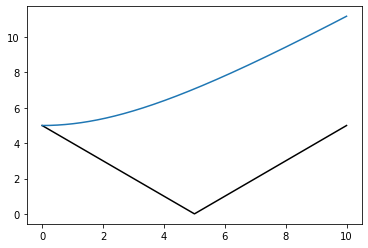

In [101]:
σ_1 = np.linspace(0,10,10000)
σ_2 = 5

y1 = np.abs(σ_1-σ_2)
y2 = np.sqrt(σ_1**2+σ_2**2)
plt.plot(σ_1,y1, c= 'k')
plt.plot(σ_1,y2)

10.0


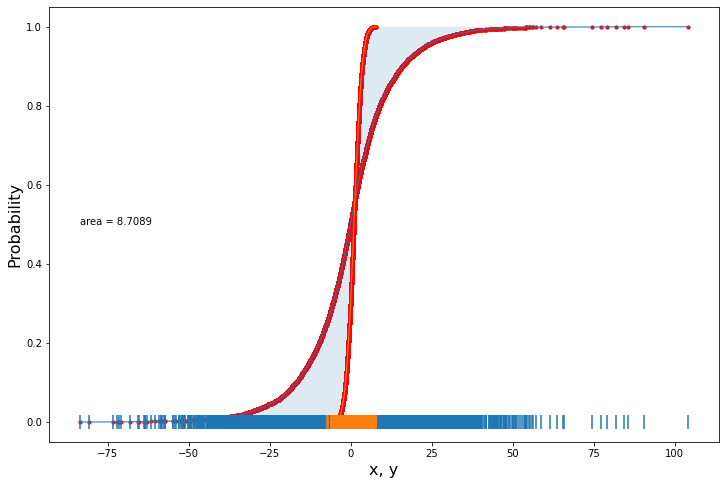

In [36]:
N = 10000
Δ = 1
ϵ = 0.1
b = Δ/ϵ
am.plot_area(np.random.laplace(0,b,N)+np.random.normal(0,2,N),np.random.normal(1,2,N))
print(b)

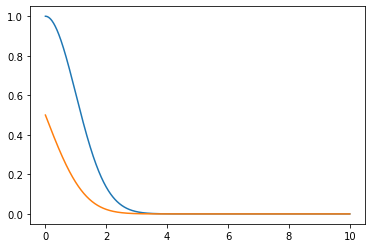

In [129]:
x = np.linspace(0,10,1000)
plt.plot(x,np.exp(-(0.5)*x**2))
plt.plot(x,norm.cdf(-x))

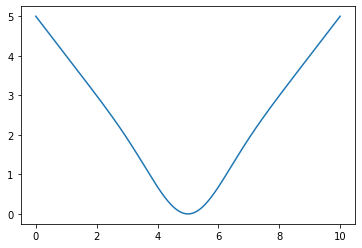

In [119]:
x = np.linspace(0,10,1000)
y = (x-5)*(1-2*norm.cdf(-(x-5)/1))
plt.plot(x,y)

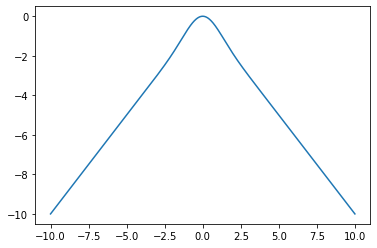

In [123]:
x = np.linspace(-10,10,1000)
plt.plot(x,x*(1-2*norm.cdf(x)))

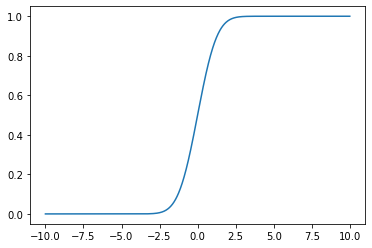

In [126]:
plt.plot(x,norm.cdf(x))